### Follow the Blog Discussion
Feel free to open and refer to the blog post to follow the analysis in more detail/discussion, link: https://showerthought5.wordpress.com/2024/04/18/the-power-creep-perspective/

### GitHub Repository Link
All progress (and complete files) for this Empirical Project can be accessed here: https://github.com/igntobias/BEE2041_Project

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
from datetime import datetime
from collections import Counter
from collections import defaultdict
from matplotlib.dates import date2num, num2date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns

# Web Scraping
Skip running this section if only the data frame is required, feel free to skip to the **Save dataframe into csv for convenience** section. This is to ensure that the data used for the blog and web scraping is streamlined, reduce uneeded traffic to the sites, as well as avoid any troubleshooting in the event that major updates/changes occur on the source sites.

### *Obtaining All Names (using genshin.gg)*

In [2]:
#Web scraping the wikia for Genshin's playable character list.
#Note: Scraping only one page from .gg

urlnames_gg = "https://genshin.gg/"

pagenames_gg = requests.get(urlnames_gg)

soupname_gg = BeautifulSoup(pagenames_gg.text, "html.parser")

In [3]:
#Scraping through to get the html, identifying which class and identifier to find the names

imgtag_gg = soupname_gg.find_all("h2", class_= "character-name")
#imgtag_gg

In [4]:
characters_gg = [element.get_text() for element in imgtag_gg]
#characters

def process_names(names_list):                                        #Create Function to change all capital
    return [name.replace(" ", "").lower() for name in names_list]

characters_gg = process_names(characters_gg)
characters_gg = sorted(characters_gg)

#print(characters_gg)

## Data Scraping and Pre-Processing
This had to be done in order to ensure that the format of the names used across both sites and for the scraping are usable and conformable for any function I will need to use. In particular, characters such as "Arataki Itto" can either be refered to by sites or scrapers as "Arataki_Itto" or simply as "Itto." Some characters do not exhibit this problem, however there are a select few characters that have different naming conventions depending on the site. Furthermore, some characters may have discrepancies/unique tags in their release dates. The character "Aloy" for example was officially released on two dates, thus I had to filter out the date where the global version of the game recieved this character. Other characters also have different aliases, thus this section seeks to streamline and create a universal naming format that the rest of the code can use.

### *Tidying Up Names*

In [5]:
remove_gg = ["itto", "kazuha", "heizou", "sara", "childe", "ayato", "ayaka", "kokomi"]

characters_gg = [item for item in characters_gg if item not in remove_gg]
characters_gg = characters_gg + remove_gg
#print(characters_gg)

### *Scraping Names and Dates from g8*
In the event of a "Type Error" warning, this is likely due to the site changing the order of the correct dataframe needed for our data. Please try and sift through the different tables in the "pandas_table_g8[X]" until the table with columns "Release Date," "Character," "Rarity," and "Element" is obtained.

In [6]:
#Scraping from game8, attempting to select the correct dataframe.

url_g8 = "https://game8.co/games/Genshin-Impact/archives/307054"


#Using the Built-in Pandas html reader
pandas_table_g8 = pd.read_html(url_g8)
#pandas_table_g8

In [7]:
#Obtaining the correct table

table = pd.DataFrame()

for tables in pandas_table_g8:
    if tables.columns.tolist() == ['Release Date', 'Character', 'Rarity', 'Element']:
        if len(tables) >= 50:
            #print("yes")
            table = tables
            
        #else:
            #print("no")
    #else:
        #print("no")

In [8]:
#dates_full_g8 = pandas_table_g8[4]
#Selecting the correct table with the release date from the scrape

dates_full_g8 = table


#Removing the irrelevant data
dates_full_g8 = dates_full_g8.drop(columns = ['Element'])
dates_full_g8 = dates_full_g8.dropna()

In [9]:
#Sorting values
dates_full_g8 = dates_full_g8.sort_values(by = ["Character"], axis = 0)
dates_full_g8.reset_index(drop=True, inplace=True)


#Fixing Aloy, Childe, and Kuki Shinobu: specific characters with issues that need to be processed manually
#with the naming and release date conventions
dates_full_g8.loc[2, 'Release Date'] = "10/13/2021"
dates_full_g8.loc[44, 'Character'] = "childe"
dates_full_g8 = dates_full_g8.drop(dates_full_g8[dates_full_g8['Character'] == "Shinobu"].index)


#Fixing Rarity Tag
dates_full_g8['Rarity'] = dates_full_g8['Rarity'].str.replace(r'★ (\d+)', r'\1star', regex=True)    #use Regex

#Fixing Release Date
dates_full_g8['Release Date'] = pd.to_datetime(dates_full_g8['Release Date'])


#Converting character names into simpler format and obtaining information on missing ("Day One") Characters
characters_g8 = dates_full_g8['Character'].tolist()
characters_g8 = [x.lower() for x in characters_g8]        #Similar to previous action with gg
characters_g8 = process_names(characters_g8)              #Use Previous function to remove spaces


#Listing out Missing Characters, comparing complete set FROM gg and the incomplete from g8
characters_gg_g8 = list(set(characters_gg) - set(characters_g8))


#Isolating Day 1 Characters into g8
characters_gg_g8 = list(set(characters_gg_g8) - set('kukishinobu'))    #kukishinobu will be added back later


#Creating 5star (legendary) and 4star (epic) dataframes for concatenation
Legendary = ['diluc', 'jean', 'traveler(geo)', 'traveler(electro)', 
             'traveler(hydro)','traveler(anemo)', 'traveler(dendro)', 
             'qiqi', 'mona', 'keqing']
Epic = list(set(characters_gg_g8) - set(Legendary))        #Manual action is listing Day One Legendary characters


#Converting Epic list into DataFrame
df_Epic = pd.DataFrame(Epic, columns=['Character'])
df_Epic['Rarity'] = '4star'
df_Epic['Release Date'] = '2020/9/28'
df_Epic['Release Date'] = pd.to_datetime(df_Epic['Release Date'])

kuki = pd.DataFrame([{'Character': 'kukishinobu',         #Adding back kukishinobu manually
                      'Rarity': '4star', 
                      'Release Date': '21/6/2022'}])
kuki['Release Date'] = pd.to_datetime(kuki['Release Date'])


df_Epic = pd.concat([df_Epic, kuki])
df_Epic.reset_index(drop = True, inplace = True)


#Converting Legendary list into DataFrame
df_Legend = pd.DataFrame(Legendary, columns=['Character'])
df_Legend['Rarity'] = '5star'
df_Legend['Release Date'] = '2020/9/28'
df_Legend['Release Date'] = pd.to_datetime(df_Epic['Release Date'])


#Combining the 5s and 4s dataframes for the Day One Characters (and kukishinobu)
df_Day1 = pd.concat([df_Epic, df_Legend])
df_Day1.reset_index(drop = True, inplace = True)


#Combining the Day One Characters with the Initial dates_full_g8 Frame
dates_full_g8 = pd.concat([dates_full_g8, df_Day1])
dates_full_g8.reset_index(inplace = True, drop = True)

In [10]:
characters_g8 = dates_full_g8['Character'].tolist()
characters_g8 = [x.lower() for x in characters_g8]
characters_g8 = process_names(characters_g8)

#print(len(dates_full_g8))
#dates_full_g8

#print(len(characters_g8))
#characters_g8

### *Scraping Character Data from genshin.gg*

Skip to next section for pd.read_csv, to avoid unecessary web scraping

In [11]:
#Web Scraping Constellation Data from Genshin.gg - Complete

characters_gg_test = characters_g8#[0:60]
cons_full_g8 = []

for names in characters_gg_test:
    
    url_chara_gg = "https://genshin.gg/characters/"+names+"/"
    page_chara_gg = requests.get(url_chara_gg)
    soup_chara_gg = BeautifulSoup(page_chara_gg.content, "html.parser")
 

    #Obtaining the constellation html info
    
    if soup_chara_gg.find("div", id='constellations') != None:
        cons1 = soup_chara_gg.find("div", id="constellations").find_all("div", class_="character-skill-description")
        cons2 = [con.get_text() for con in cons1]
        cons2 = " ".join(cons2)
        #print(cons2)
        cons_full_g8.append(cons2)
    
    else:
        #print("No Constellations")
        notext = "This character has no constellations."
        cons_full_g8.append(notext)

In [12]:
len(cons_full_g8)

#cons_full_g8
#dates_full_g8

#Note: Set limit as desired
pd.set_option('display.max_rows', 10)

In [13]:
#Adding the constellation descriptions into the ready-made dataframe
dates_full_g8['Constellation Description'] = cons_full_g8

#Renaming into new DF
df1 = dates_full_g8
#display(df1)

In [14]:
#Generating a simple word count from the constellation descriptions and adding it as a new column

List_count_g8 = []

for paragraph in cons_full_g8:
    words = paragraph.split()
    word_count = sum(Counter(words).values())
    List_count_g8.append(word_count)

#print(List_count_g8)
#len(List_count_g8)

df1['Word Count'] = List_count_g8

### *Save dataframe into csv for convenience*

Select file path/directory as required

In [15]:
#Saving Output from Data Frame 1 into csv (to decrease uneccesary web scrape loading) part 2

#df1.to_csv("/Users/ignatiustobiassoetjianto/Desktop/df1_wc.csv", index = False)

In [14]:
df1 = pd.read_csv('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/df1.csv')
df1['Release Date'] = pd.to_datetime(df1['Release Date'])
display(df1)

,Release Date,Character,Rarity,Constellation Description,Word Count
0,2020-12-23,Albedo,5star,Transient Blossoms generated by Albedo's Abiog...,141
1,2023-01-18,Alhaitham,5star,"When a Projection Attack hits an opponent, Uni...",252
2,2021-10-13,Aloy,5star,This character has no constellations.,5
3,2021-07-01,Ayaka,5star,When Kamisato Ayaka's Normal or Charged Attack...,138
4,2022-03-30,Ayato,5star,Shunsuiken DMG is increased by 40% against opp...,121
...,...,...,...,...,...
80,2020-09-28,traveler(anemo),5star,Palm Vortex pulls in enemies within a 5m radiu...,80
81,2020-09-28,traveler(dendro),5star,"After Razorgrass Blade hits an opponent, it wi...",126
82,2020-09-28,qiqi,5star,When the Herald of Frost hits an enemy marked ...,102
83,2020-09-28,mona,5star,The effects of Hydro-related Elemental Reactio...,165


# Functions

In [16]:
#Create Function that count specific words/strings

def count_target_words(Input, Target):
    words = Input.split()
    count = 0
    
    
    for target in Target:
        for word in words:
#        word = word.strip('.,?!:;-()[]{}\'"')
    
            if word == target:
                count += 1
    
    return count

In [17]:
#Creating new Function to generate new dataframe column "Key Count"

def create_key_count_col(dataframe):

    key_words = ['crit', 'energy', 'increase', 'increases', 'decrease', 'decreases', 'recharge', 'atk',
                 'dmg', 'elemental', 'element', 'refund', 'attacks', 'reaction', 'reactions', 'attack']
    
    test1 = dataframe#.drop(columns = ['Word Count'])
    
    if 'Constellation Desc' in test1.columns and 'Key Count' in test1.columns:
        return test1
    
    else:    
        test1['Constellation Desc'] = test1['Constellation Description'].replace(".", "").replace('(', "").replace(')', "")
        test1['Constellation Desc'] = test1['Constellation Desc'].apply(lambda x: x.lower())
        test1 = test1.drop(columns = ['Constellation Description'])

#Aggregate of all "Meaningful" key word stats.
        test1['Key Count'] = test1['Constellation Desc'].apply(lambda x: count_target_words(x, key_words))
                                                           
        return test1


In [18]:
#Creating a function to make the subplot system


def get_keyword_count_scatter(dataframe):

    #Setting Subplots
    dataframe_TEST, ax = plt.subplots(1, 2, figsize=(12, 5))

    #Checking Rarity
    rarity_types = dataframe['Rarity'].unique().tolist()

    dataframe = create_key_count_col(dataframe)        #Create column using create_key_count_col
    
    #Scatter Plot
    if len(rarity_types) == 2:
        
        X1_test = dataframe['Release Date']                #Generate Data
        X1_test_int = X1_test.astype(int)
        Y1_test = dataframe['Key Count']
        dataframe_set = np.polyfit(X1_test_int, Y1_test, 1)
        dataframe_line = np.poly1d(dataframe_set)
        r_value = np.corrcoef(X1_test_int, Y1_test)[0, 1]
        
        ax[0].scatter(X1_test, Y1_test, color='blue',
                      marker = 'o', edgecolor = 'black', alpha = 0.75, s = 150)

        ax[0].set_xlabel('Release Date', fontweight = "bold")
        ax[0].set_ylabel('Key Words Count', fontweight = "bold")
        ax[0].set_title('Scatter Plot of Character Constellation key words overtime')
        ax[0].set_ylim(0, 18)

    else:        
        X1_test = dataframe['Release Date']
        X1_test_int = X1_test.astype(int)
        Y1_test = dataframe['Key Count']
        dataframe_set = np.polyfit(X1_test_int, Y1_test, 1)
        dataframe_line = np.poly1d(dataframe_set)
        r_value = np.corrcoef(X1_test_int, Y1_test)[0, 1]
        
        if dataframe['Rarity'][0] == '4star':
            ax[0].scatter(X1_test, Y1_test, color='#945dc4',
                          marker = 'o', edgecolor = 'black', alpha = 0.75, s = 150)

            ax[0].set_xlabel('Release Date', fontweight = "bold")
            ax[0].set_ylabel('Key Words Count', fontweight = "bold")
            ax[0].set_title('Scatter Plot of 4 star Character key words overtime')
            ax[0].set_ylim(0, 18)


        else:
            ax[0].scatter(X1_test, Y1_test, color='#dca454',
                          marker = 'o', edgecolor = 'black', alpha = 0.75, s = 150)

            ax[0].set_xlabel('Release Date', fontweight = "bold")
            ax[0].set_ylabel('Key Words Count', fontweight = "bold")
            ax[0].set_title('Scatter Plot of 5 star Character key words overtime')
            ax[0].set_ylim(0, 18)

    #Line of Best Fit
    ax[1].plot(X1_test_int, dataframe_line(X1_test_int), color = 'red', 
               label = f'Line of Best Fit (r={r_value:.3f})')

    ax[1].set_xlabel('Time', fontweight = "bold")
    ax[1].set_ylabel('Key Words Count', fontweight = "bold")
    ax[1].set_title('Line of Best Fit')
    ax[1].set_ylim(0, 18)

    #Formatting x-axis
    for axis in ax:
        axis.tick_params(axis = 'x', rotation=30)
        axis.grid(True)
    
    
    #Display the plot
    plt.tight_layout()
    plt.legend()
    #plt.show()
    
    return dataframe_TEST

In [19]:
#Creating a function to make a histogram subplots


def get_keyword_count_histogram(dataframe):
    
    #Setting figure
    fig = plt.figure()
    
    #Aggregating all descriptions into one paragraph.
    dataframe_cons_all = ' '.join(dataframe['Constellation Description'])

    #Cleaning the paragraph
    testing1 = dataframe_cons_all.replace(".", "").replace('(', "").replace(')', "")
    testing2 = testing1.lower().split()                #Splitting paragraphs by word
    testing3 = Counter(testing2).most_common(15)       #Making a word count and distribution
                                                       #Choose the top frequencies as desired
 
    #Converting into usable DataFrame
    testing4 = pd.DataFrame(testing3, columns=['Word', 'Frequency'])
    testing4 = testing4[::-1]

    #Check rarities contained in dataframe
    rarity_types = dataframe['Rarity'].unique().tolist()

    #Plotting into bar chart
    if len(rarity_types) == 2:                         #Checks if there is only one or two rarities
        plt.barh(testing4['Word'], testing4['Frequency'], color = "blue")
        plt.xlabel('Frequency', fontsize = 11, fontweight = 'bold')
        plt.ylabel('Words', fontsize = 10, fontweight = 'bold')
        plt.title('Word Frequency Distribution of Character Constellations')
        plt.xticks(rotation=0, fontsize = 10)

    else:
        if dataframe['Rarity'][0] == '4star':
            plt.barh(testing4['Word'], testing4['Frequency'], color = "#945dc4")
            plt.xlabel('Frequency', fontsize = 11, fontweight = 'bold')
            plt.ylabel('Words', fontsize = 10, fontweight = 'bold')
            plt.title('Word Frequency Distribution of 4star Constellations')
            plt.xticks(rotation=0, fontsize = 10)
        
        else:
            plt.barh(testing4['Word'], testing4['Frequency'], color = "#dca454")
            plt.xlabel('Frequency', fontsize = 11, fontweight = 'bold')
            plt.ylabel('Words', fontsize = 10, fontweight = 'bold')
            plt.title('Word Frequency Distribution of 5star Constellations')
            plt.xticks(rotation=0, fontsize = 10)
 
    #plt.show()
    return  fig

# Data Processing

## *Plots (no discrimination)*

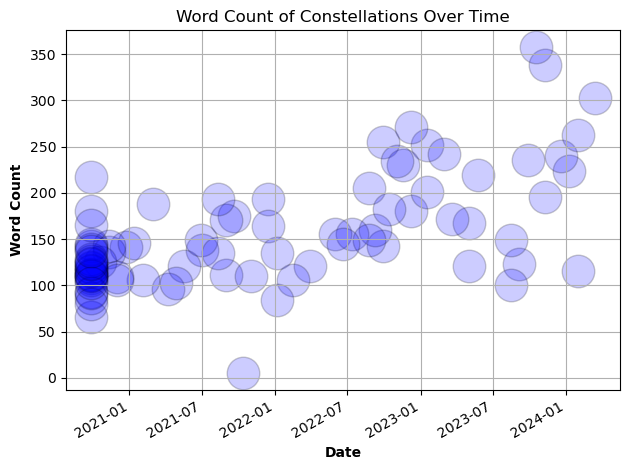

In [20]:
#Creating plots with the new data frame.

ManualFig5 = plt.figure()

plt.scatter(x=df1['Release Date'], y = df1['Word Count'], color = 'blue',
                 marker = 'o', edgecolor = 'black', alpha = 0.20, s=550)


# Adding labels and title
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('Word Count', fontweight = 'bold')
plt.title('Word Count of Constellations Over Time')

# Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


#Saving the Figure
#ManualFig5.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Word Count of Constellations Over Time')
#display(ManualFig5)

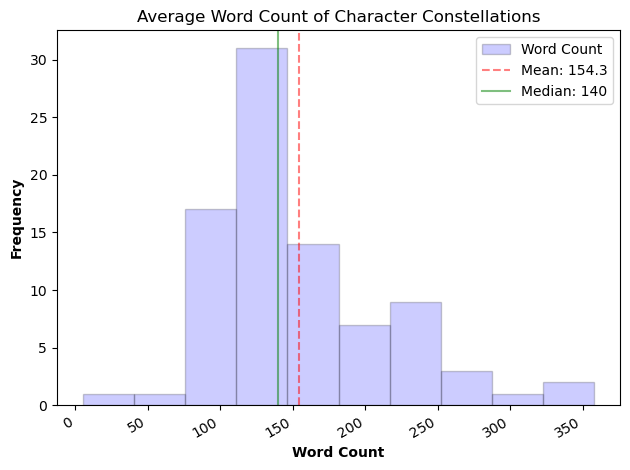

In [21]:
#Histogram of Frequency of "Word Count:" Average Word Count of Character Constellations

df1.plot.hist(y='Word Count', color='blue', edgecolor='black', alpha = 0.20)

#Calculate Mean and Median
mean_stat = df1['Word Count'].mean()
median_stat = df1['Word Count'].median()

plt.axvline(x=mean_stat, color = 'red', linestyle = '--', 
            label = f'Mean: {round(mean_stat, 1)}', alpha = 0.5)
plt.axvline(x=median_stat, color = 'green', linestyle = '-', 
            label = f'Median: {round(median_stat)}', alpha = 0.5)


#Adding labels and title
plt.xlabel('Word Count', fontweight = 'bold')
plt.ylabel('Frequency', fontweight = 'bold')
plt.title('Average Word Count of Character Constellations')
plt.legend()

#Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

#Display the plot
plt.tight_layout()
plt.show()

In [22]:
#Summary Statistics of Word Count

df1_summary = df1.describe()
display(df1_summary)

,Word Count
count,86.000000
mean,154.302326
std,60.489001
min,5.000000
25%,111.250000
50%,140.000000
75%,182.250000
max,358.000000


## *Grouping by Rarity*

Creating initial dataframes for 4 star and 5 star characters.

In [23]:
#Summary Statistics according to character rarity

df1_summary = df1.groupby('Rarity')
display(df1_summary.mean())

,Word Count
Rarity,
4star,138.902439
5star,168.333333


In [24]:
#Splitting original dataframe into a list, and then converting the list into a pd.DataFrame

Rarity = df1.groupby('Rarity')
df1_Rarity = [group_df for _, group_df in Rarity]
df1_Epic, df1_Legendary = df1_Rarity

In [25]:
df1_Epic.reset_index(inplace = True, drop = True)
df1_Legendary.reset_index(inplace = True, drop = True)

#display(df1_Epic)
#display(df1_Legendary)

## *Scatter Plots (with discrimination)*

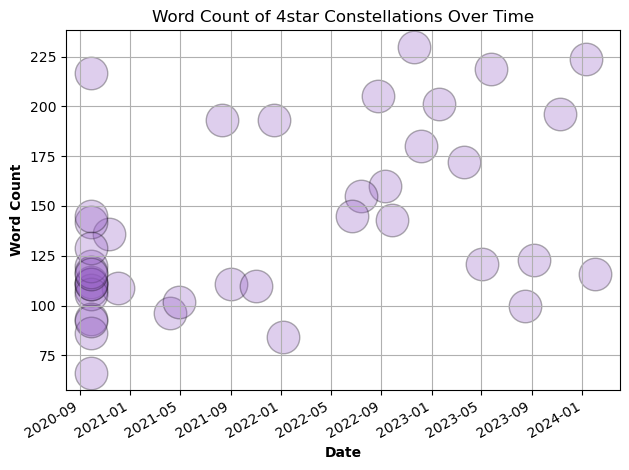

In [26]:
#Creating plots for Epic Rarities

ManualFig6 = plt.figure()

plt.scatter(x=df1_Epic['Release Date'], y = df1_Epic['Word Count'], color='#945dc4',
            marker = 'o', edgecolor = 'black', alpha = 0.30, s = 550)

# Adding labels and title
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('Word Count', fontweight = 'bold')
plt.title('Word Count of 4star Constellations Over Time')

# Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

#Saving the Figure
#ManualFig6.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Word Count of 4-star Constellations Over Time')
#display(ManualFig6)

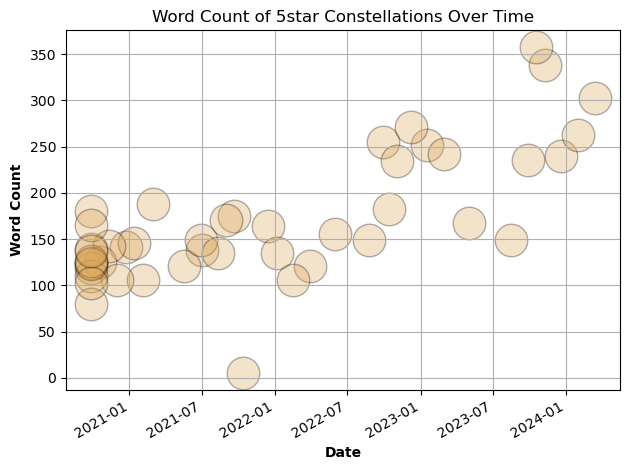

In [27]:
#Creating plots for Legendary Rarities
ManualFig7 = plt.figure()

plt.scatter(x=df1_Legendary['Release Date'], y = df1_Legendary['Word Count'], color='#dca454',
            marker = 'o', edgecolor = 'black', alpha = 0.30, s = 550)

# Adding labels and title
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('Word Count', fontweight = 'bold')
plt.title('Word Count of 5star Constellations Over Time')

# Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

#Saving the Figure
#ManualFig7.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Word Count of 5-star Constellations Over Time')
#display(ManualFig7)

## *Insight: "Quality" of Constellations*
Using previous created functions

In [28]:
pd.set_option('display.max_rows', 10)

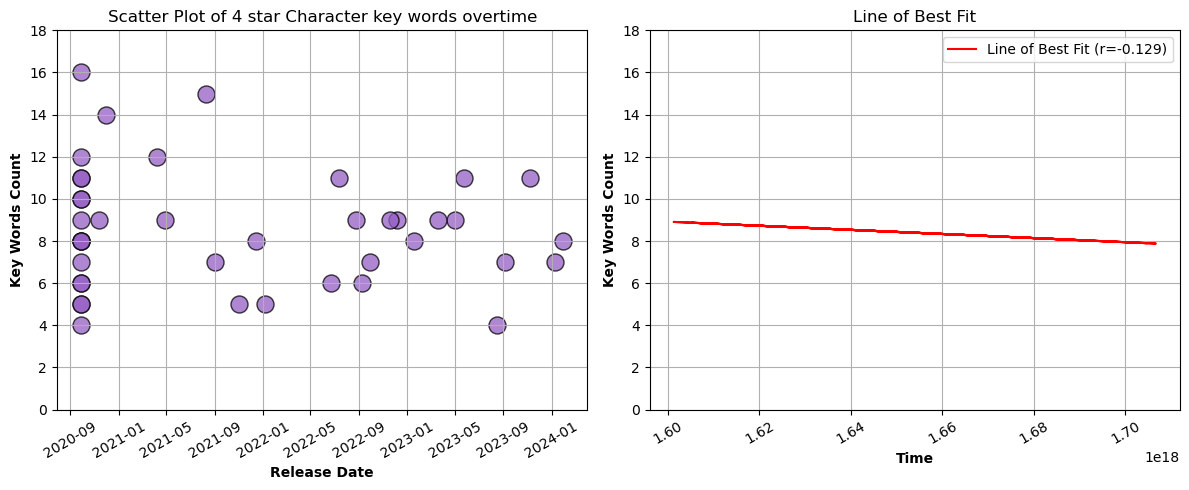

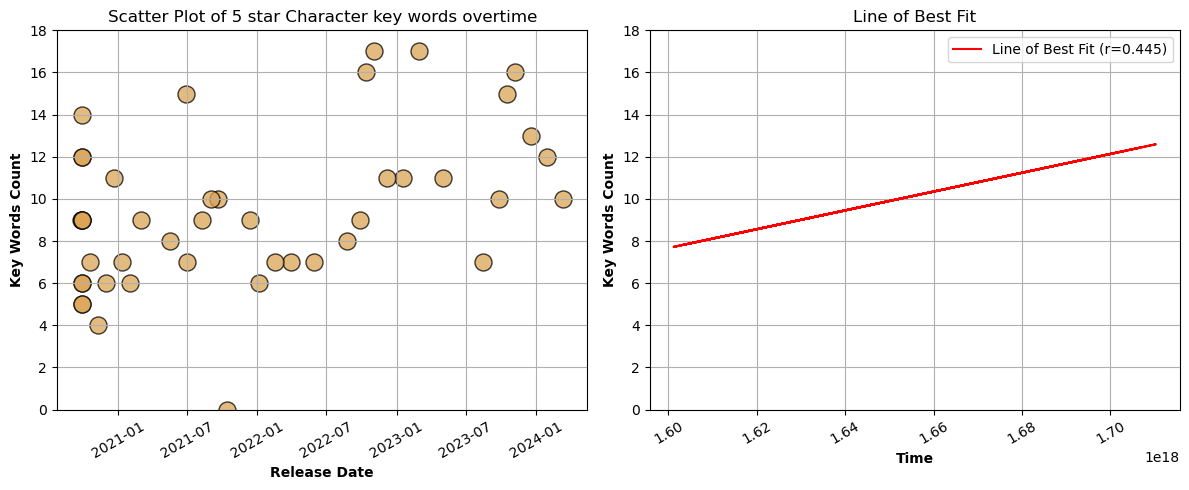

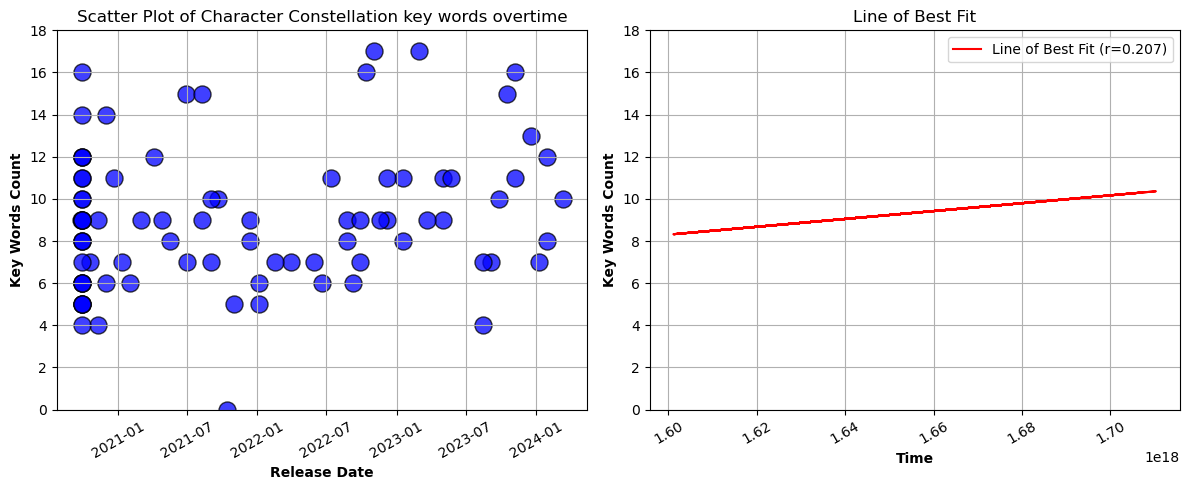

In [29]:
fig_scat_1 = get_keyword_count_scatter(df1_Epic)
fig_scat_2 = get_keyword_count_scatter(df1_Legendary)
fig_scat_3 = get_keyword_count_scatter(df1)

In [30]:
#For saving the figures

#fig_scat_1.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   '4star Constellation Key Word Scatter')
#fig_scat_2.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   '5star Constellation Key Word Scatter')
#fig_scat_3.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Character Constellation Key Word Scatter')

## *Insight: "Quality" of Constellations Calculated*

In [31]:
#Summary statistics for quality
df2 = create_key_count_col(df1)
df2['Quality'] = round(df2['Key Count']/df2['Word Count'], 3)

Table2 = df2.describe().round(3)
display(Table2)

,Word Count,Key Count,Quality
count,86.000,86.000,86.000
mean,154.302,9.012,0.061
std,60.489,3.299,0.022
min,5.000,0.000,0.000
25%,111.250,7.000,0.045
50%,140.000,9.000,0.057
75%,182.250,11.000,0.074
max,358.000,17.000,0.128


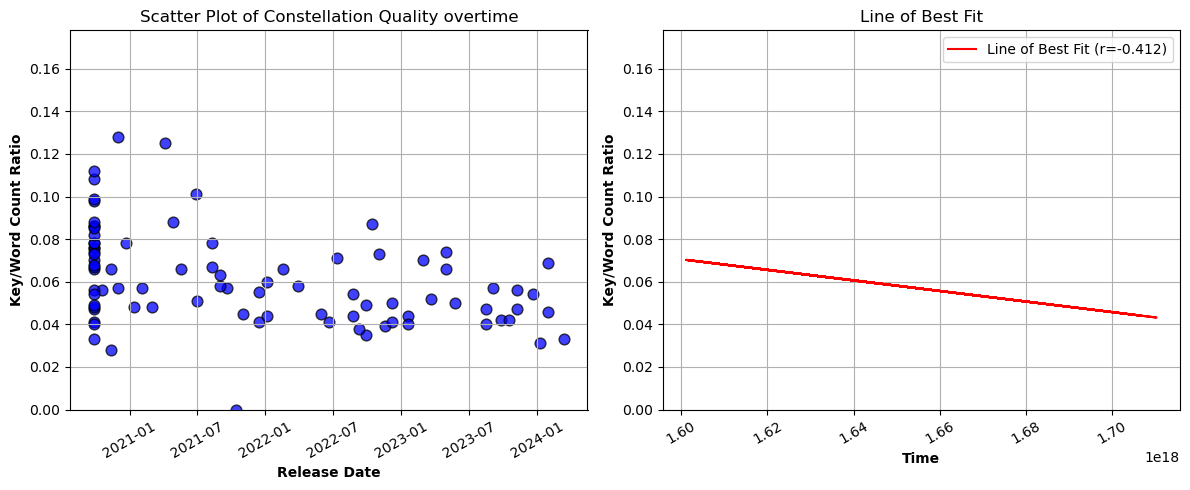

In [32]:
ManualFig1, ax = plt.subplots(1, 2, figsize=(12, 5))

X1_test = df2["Release Date"]
Y1_test = df2["Quality"]

X1_test_int = X1_test.astype(int)
dataframe_set = np.polyfit(X1_test_int, Y1_test, 1)
dataframe_line = np.poly1d(dataframe_set)
r_value = np.corrcoef(X1_test_int, Y1_test)[0, 1]

#Scatter Plot
ax[0].scatter(X1_test, Y1_test, color='blue',
             marker = 'o', edgecolor = 'black', alpha = 0.75, s = 60)

ax[0].set_xlabel('Release Date', fontweight = "bold")
ax[0].set_ylabel('Key/Word Count Ratio', fontweight = "bold")
ax[0].set_title('Scatter Plot of Constellation Quality overtime')
ax[0].set_ylim(0, max(Y1_test) + 0.05)         #Custom graph sizes

#Line of Best Fit
ax[1].plot(X1_test_int, dataframe_line(X1_test_int), color = 'red', 
            label = f'Line of Best Fit (r={r_value:.3f})')

ax[1].set_xlabel('Time', fontweight = "bold")
ax[1].set_ylabel('Key/Word Count Ratio', fontweight = "bold")
ax[1].set_title('Line of Best Fit')
ax[1].set_ylim(0, max(Y1_test) + 0.05)

#Formatting x-axis
for axis in ax:
    axis.tick_params(axis = 'x', rotation=30)
    axis.grid(True)

#Display the plot
plt.tight_layout()
plt.legend()
plt.show()

#Saving Data
#ManualFig1.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Constellation Quality Scatter')

## *Insight: "Quality" of Constellations when Excluding Launch Characters*
Create alternative dataframes to isolate the impact of "Day One" characters. Checking to see if the data would be less skewed.

In [33]:
pd.set_option('display.max_rows', 10)

#Exclude 28th September 2020 characters
df1_alter = df1[df1.loc[:, 'Release Date'] != pd.to_datetime('2020-09-28')]
df1_alter.reset_index(inplace = True, drop = True)
#display(df1_alter)

In [34]:
#Segregating by rarity again.
Rarity = df1_alter.groupby('Rarity')
df1_Rarity_alter = [group_df for _, group_df in Rarity]

df1_Epic_alter, df1_Legendary_alter = df1_Rarity_alter
df1_Epic_alter.reset_index(inplace = True, drop = True)
df1_Legendary_alter.reset_index(inplace = True, drop = True)

#Display
#display(df1_Epic_alter)
#display(df1_Legendary_alter)

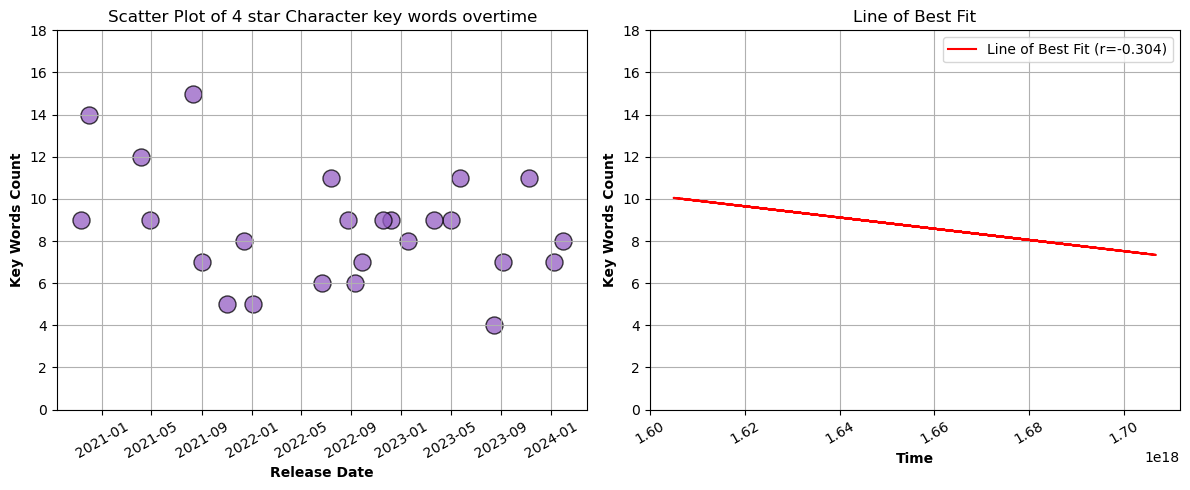

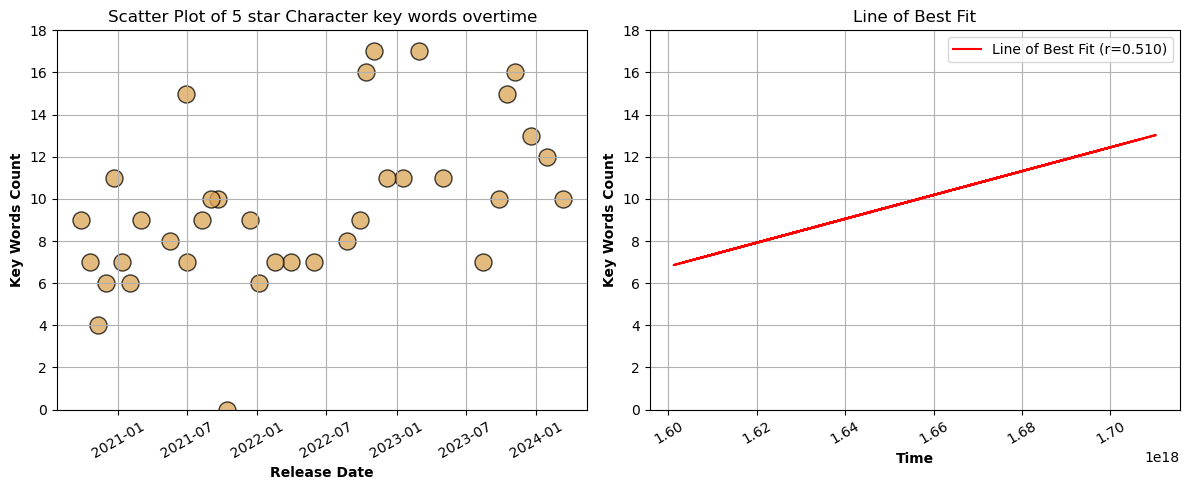

In [35]:
fig_scat_1_alter = get_keyword_count_scatter(df1_Epic_alter)
fig_scat_2_alter = get_keyword_count_scatter(df1_Legendary_alter)

In [36]:
#For saving the figures

#fig_scat_1_alter.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                         '4star Constellation Quality (alter) Scatter')
#fig_scat_2_alter.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                         '5star Constellation Quality (alter) Scatter')

### *Grouping also by Rarity*

In [37]:
df2_alter = df2[df2.loc[:, 'Release Date'] != pd.to_datetime('2020-09-28')]
df2_alter.reset_index(inplace = True, drop = True)
#display(df2_alter)

In [38]:
#Splitting DF2 into a list, and then converting the list into a pd.DataFrame

Rarity = df2_alter.groupby('Rarity')
df2_Rarity_alter = [group_df for _, group_df in Rarity]
df2_Epic_alter, df2_Legendary_alter = df2_Rarity_alter

In [39]:
df2_Epic_alter.reset_index(inplace = True, drop = True)
df2_Legendary_alter.reset_index(inplace = True, drop = True)

#display(df2_Epic)
#display(df2_Legendary)

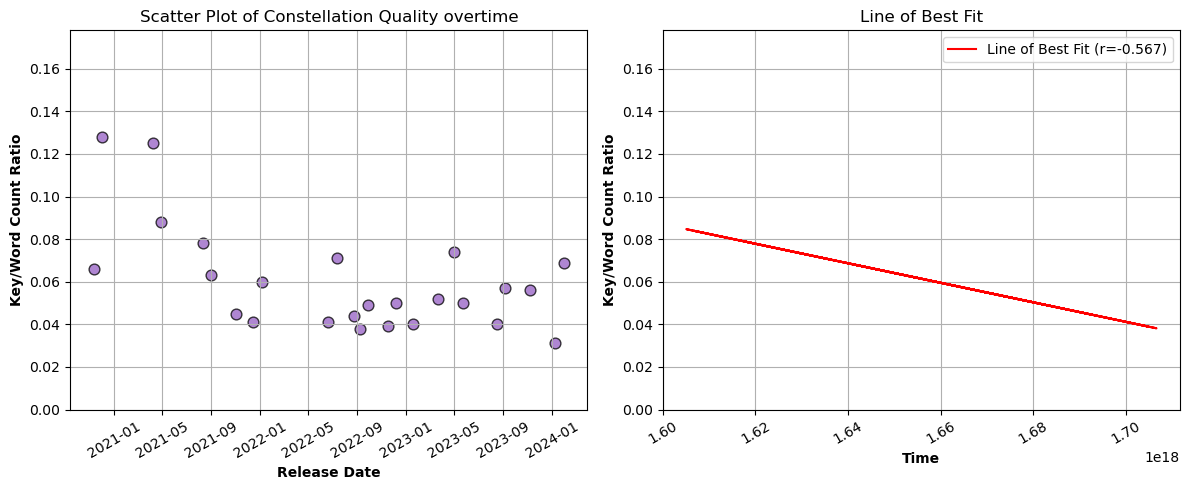

In [40]:
ManualFig2, ax = plt.subplots(1, 2, figsize=(12, 5))

X1_test = df2_Epic_alter["Release Date"]
Y1_test = df2_Epic_alter["Quality"]

X1_test_int = X1_test.astype(int)
dataframe_set = np.polyfit(X1_test_int, Y1_test, 1)
dataframe_line = np.poly1d(dataframe_set)
r_value = np.corrcoef(X1_test_int, Y1_test)[0, 1]

#Scatter Plot
ax[0].scatter(X1_test, Y1_test, color='#945dc4',
             marker = 'o', edgecolor = 'black', alpha = 0.75, s = 60)

ax[0].set_xlabel('Release Date', fontweight = "bold")
ax[0].set_ylabel('Key/Word Count Ratio', fontweight = "bold")
ax[0].set_title('Scatter Plot of Constellation Quality overtime')
ax[0].set_ylim(0, max(Y1_test) + 0.05)         #Custom graph sizes

#Line of Best Fit
ax[1].plot(X1_test_int, dataframe_line(X1_test_int), color = 'red', 
            label = f'Line of Best Fit (r={r_value:.3f})')

ax[1].set_xlabel('Time', fontweight = "bold")
ax[1].set_ylabel('Key/Word Count Ratio', fontweight = "bold")
ax[1].set_title('Line of Best Fit')
ax[1].set_ylim(0, max(Y1_test) + 0.05)

#Formatting x-axis
for axis in ax:
    axis.tick_params(axis = 'x', rotation=30)
    axis.grid(True)

#Display the plot
plt.tight_layout()
plt.legend()
plt.show()

#Saving the Plot
#ManualFig1.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   '4-star Constellation Quality Over Time')

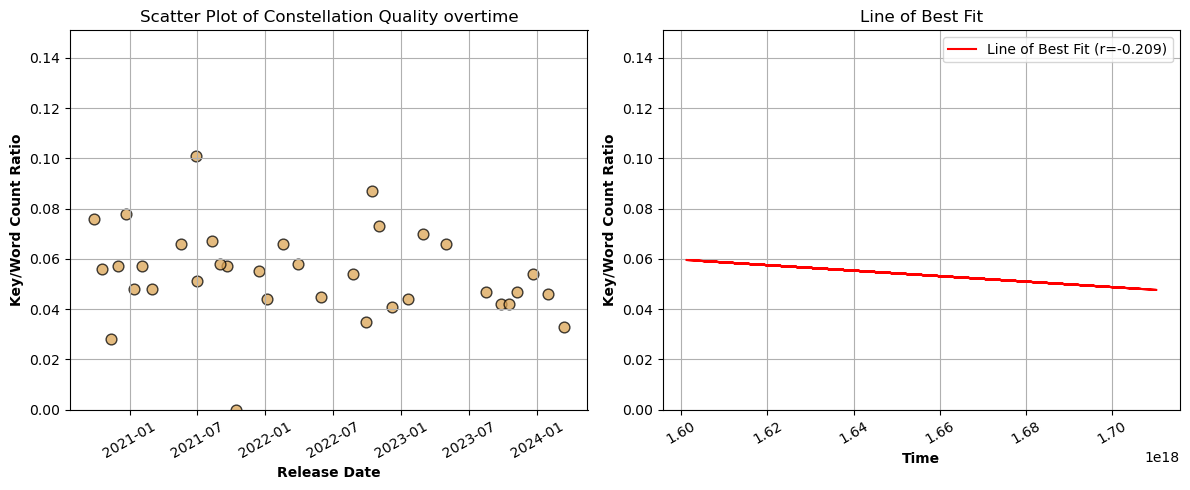

In [41]:
ManualFig2, ax = plt.subplots(1, 2, figsize=(12, 5))

X1_test = df2_Legendary_alter["Release Date"]
Y1_test = df2_Legendary_alter["Quality"]

X1_test_int = X1_test.astype(int)
dataframe_set = np.polyfit(X1_test_int, Y1_test, 1)
dataframe_line = np.poly1d(dataframe_set)
r_value = np.corrcoef(X1_test_int, Y1_test)[0, 1]

#Scatter Plot
ax[0].scatter(X1_test, Y1_test, color='#dca454',
             marker = 'o', edgecolor = 'black', alpha = 0.75, s = 60)

ax[0].set_xlabel('Release Date', fontweight = "bold")
ax[0].set_ylabel('Key/Word Count Ratio', fontweight = "bold")
ax[0].set_title('Scatter Plot of Constellation Quality overtime')
ax[0].set_ylim(0, max(Y1_test) + 0.05)         #Custom graph sizes

#Line of Best Fit
ax[1].plot(X1_test_int, dataframe_line(X1_test_int), color = 'red', 
            label = f'Line of Best Fit (r={r_value:.3f})')

ax[1].set_xlabel('Time', fontweight = "bold")
ax[1].set_ylabel('Key/Word Count Ratio', fontweight = "bold")
ax[1].set_title('Line of Best Fit')
ax[1].set_ylim(0, max(Y1_test) + 0.05)

#Formatting x-axis
for axis in ax:
    axis.tick_params(axis = 'x', rotation=30)
    axis.grid(True)

#Display the plot
plt.tight_layout()
plt.legend()
plt.show()

#Saving the Plot
#ManualFig2.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   '5-star Constellation Quality Over Time')

## *Insight: word frequency distribution*
Using previously created functions

In [42]:
pd.set_option('display.max_rows', 10)

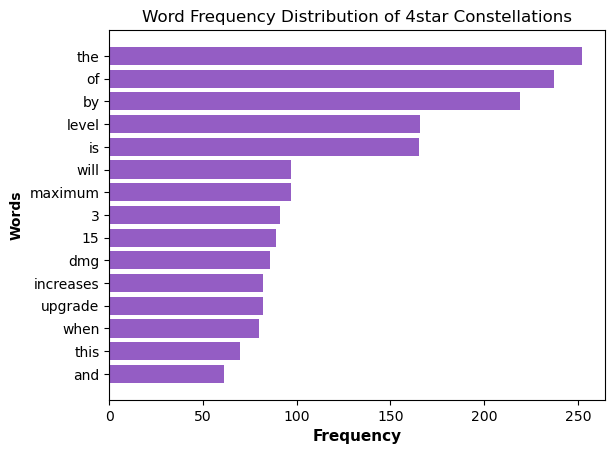

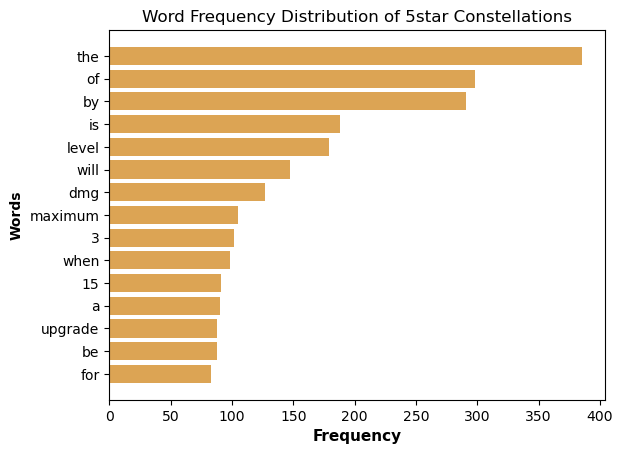

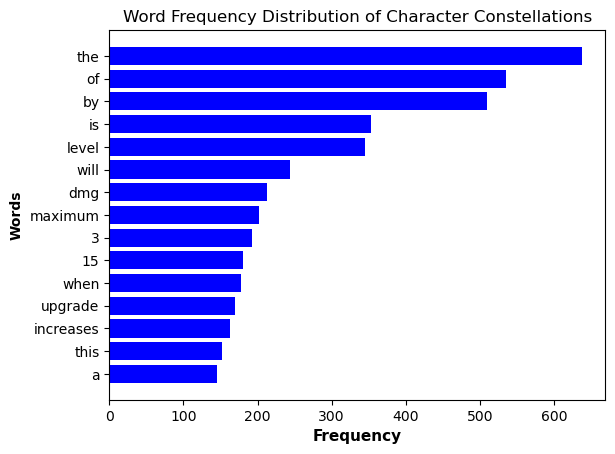

In [43]:
fig_hist_1 = get_keyword_count_histogram(df1_Epic)
fig_hist_2 = get_keyword_count_histogram(df1_Legendary)
fig_hist_3 = get_keyword_count_histogram(df1)

In [44]:
#For saving the figures

#fig_hist_1.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   '4star Constellation Frequency Distribution (words)')
#fig_hist_2.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   '5star Constellation Frequency Distribution (words)')
#fig_hist_3.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Character Constellation Frequency Distribution (words)')

### *Comparing with ZipF's Law*

In [45]:
#Obtaining frequency statistic to be used
#display(df1)

Total_Words = df1['Word Count'].sum()
#Total_Words                                       #Word count of all constellation descriptions

#Aggregating all descriptions into one string.
dataframe_cons_all = ' '.join(df1['Constellation Description'])

#Cleaning the paragraph
testing1 = dataframe_cons_all.replace(".", "").replace('(', "").replace(')', "")
testing2 = testing1.lower().split()                #Splitting paragraphs by word
testing3 = Counter(testing2).most_common(15)       #Making a word count and distribution
                                                   #Choose the top frequencies as desired

#Converting into usable DataFrame
testing4 = pd.DataFrame(testing3, columns=['Word', 'Frequency'])

#Comparing it with Forecasted ZipF Law
testing4['Nth Order'] = testing4.index + 1
testing4['Freq ZipF'] = round(testing4['Frequency'][0]/testing4['Nth Order'], 1)

#Cleaning the table
testing4['Freq%'] = round(testing4['Frequency']/Total_Words, 3)
testing4['Freq% ZipF'] = round(testing4['Freq ZipF']/Total_Words, 3)
#testing4 = testing4.drop(columns = 'Nth Order')

display(testing4)

,Word,Frequency,Nth Order,Freq ZipF,Freq%,Freq% ZipF
0,the,637,1,637.0,0.048,0.048
1,of,535,2,318.5,0.040,0.024
2,by,510,3,212.3,0.038,0.016
3,is,353,4,159.2,0.027,0.012
4,level,345,5,127.4,0.026,0.010
...,...,...,...,...,...,...
10,when,178,11,57.9,0.013,0.004
11,upgrade,170,12,53.1,0.013,0.004
12,increases,163,13,49.0,0.012,0.004
13,this,152,14,45.5,0.011,0.003


[]

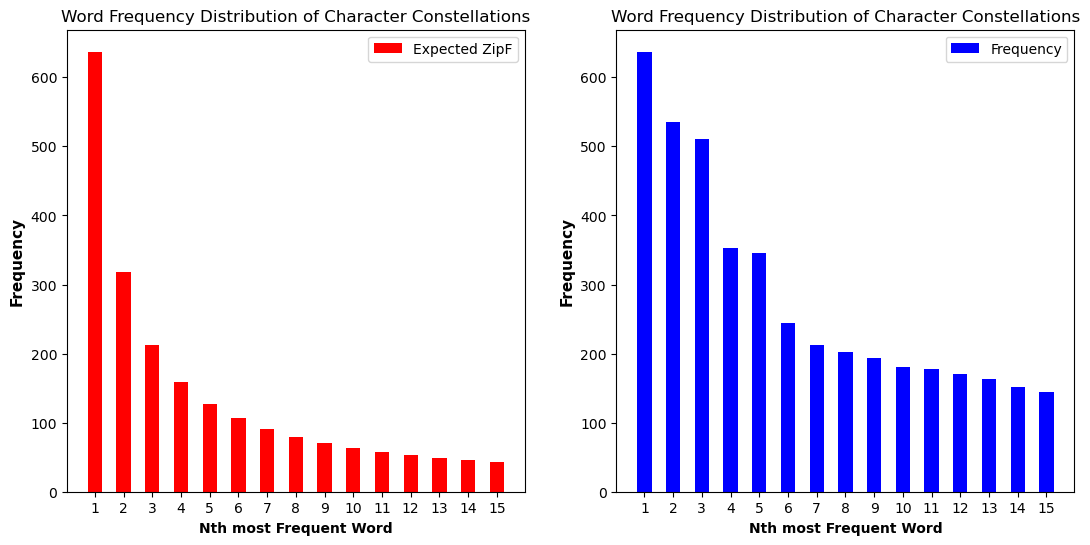

In [46]:
#Data Collection for Graph 1
X1 = testing4['Nth Order'].tolist()
Y1 = testing4['Freq ZipF'].tolist()
Y2 = testing4['Frequency'].tolist()

ManualFig3, ax = plt.subplots(1, 2, figsize=(13, 6))

ax[0].bar(X1, Y1, color = "red", alpha = 1, label = 'Expected ZipF', width = 0.5)
ax[1].bar(X1, Y2, color = "blue", alpha = 1, label = 'Frequency', width = 0.5)

for axis in ax:
    axis.set_ylabel('Frequency', fontsize = 11, fontweight = 'bold')
    axis.set_xlabel('Nth most Frequent Word', fontsize = 10, fontweight = 'bold')
    axis.set_title('Word Frequency Distribution of Character Constellations')
    axis.set_xticks(X1)
    axis.legend()

plt.plot()

#Saving the Figure
#ManualFig3.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Character Constellation Frequency Distribution')
#display(ManualFig2)

[]

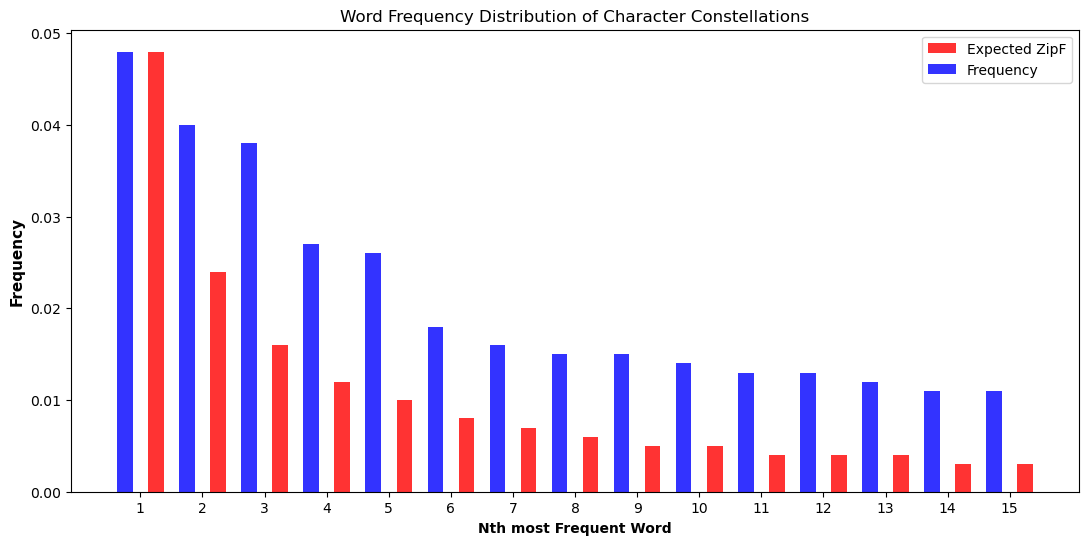

In [47]:
#Data Collection for Graph 2
X1 = testing4['Nth Order'].apply(lambda x:x+0.25).tolist()
X2 = testing4['Nth Order'].apply(lambda x:x-0.25).tolist()
Y1 = testing4['Freq% ZipF'].tolist()
Y2 = testing4['Freq%'].tolist()

ManualFig4 = plt.figure(figsize=(13, 6))

plt.bar(X1, Y1, color = "red", alpha = 0.8, label = 'Expected ZipF', width = 0.25)
plt.bar(X2, Y2, color = "blue", alpha = 0.8, label = 'Frequency', width = 0.25)

plt.ylabel('Frequency', fontsize = 11, fontweight = 'bold')
plt.xlabel('Nth most Frequent Word', fontsize = 10, fontweight = 'bold')
plt.title('Word Frequency Distribution of Character Constellations')
plt.xticks(testing4['Nth Order'])
plt.legend()

plt.plot()

#Saving the Figure
#ManualFig4.savefig('/Users/ignatiustobiassoetjianto/Desktop/720027223/BEE2041_Project/Data_files/'
#                   'Character Constellation Frequency Distribution 2')
#display(ManualFig2)